<a href="https://colab.research.google.com/github/shuklapankaj36/TensorFlow-Course/blob/master/Unet%20based%20semantic%20segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import natsort
from sklearn.model_selection import train_test_split
import tensorflow as tf
cwd = os.getcwd()
import os
cwd = os.getcwd()
import cv2
# function for face detection with mtcnn
from tensorflow.keras.utils import to_categorical
from keras.metrics import MeanIoU
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate


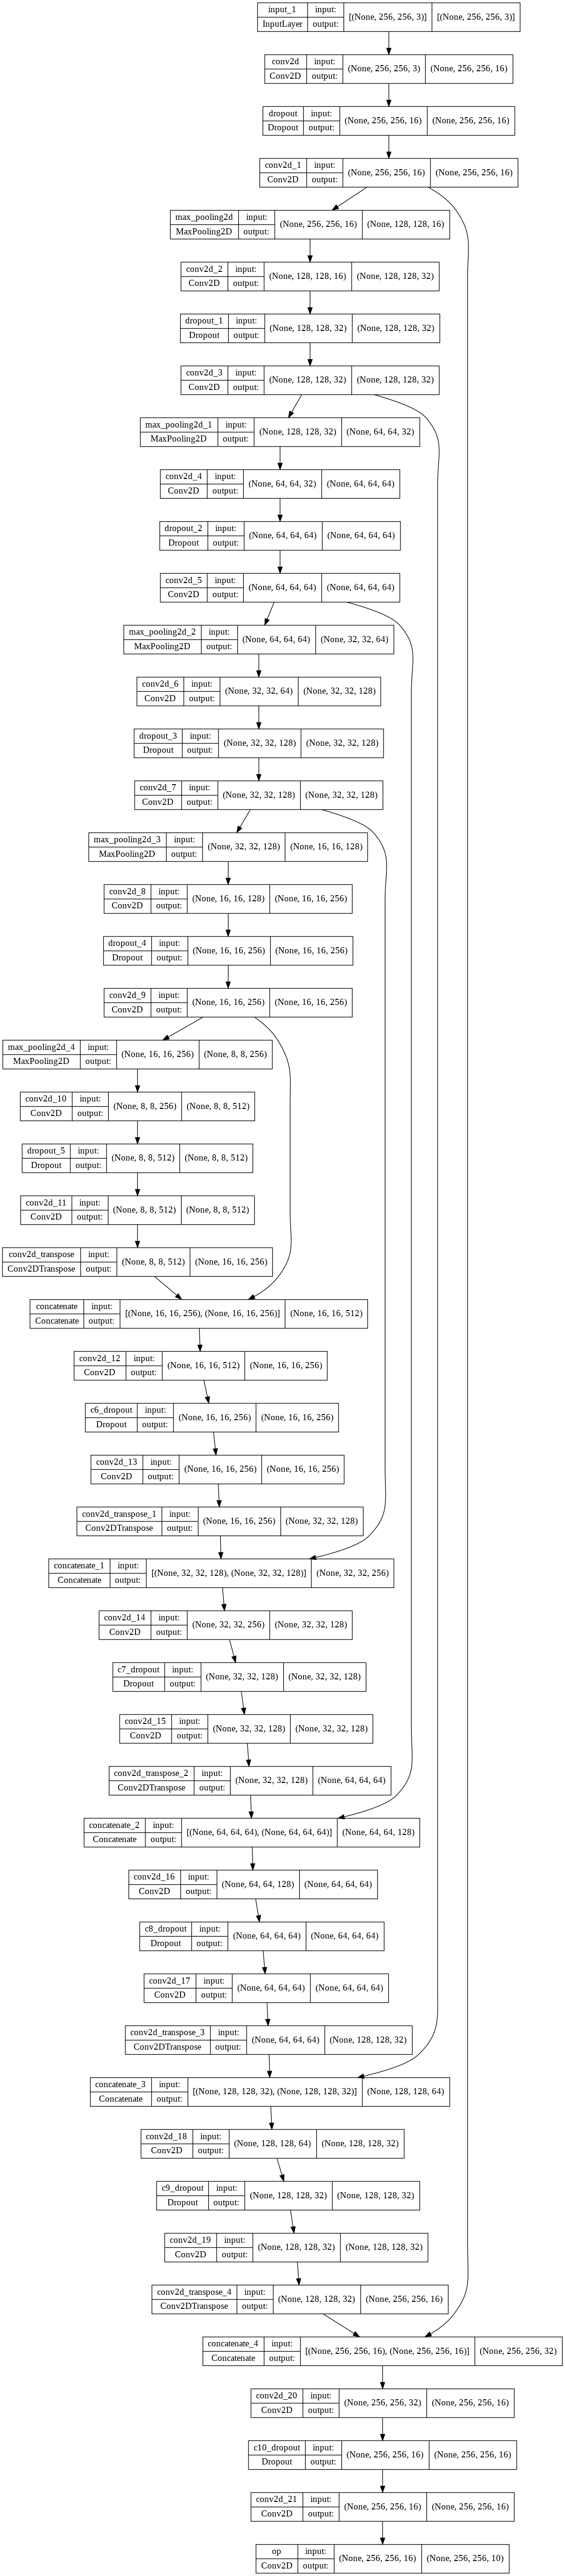

In [3]:

NUM_CLASS=10
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

#Build the model
inputs =Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
 
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = MaxPooling2D(pool_size=(2, 2))(c5)

c0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c0 = Dropout(0.1)(c0)
c0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c0)


#Expansive path 
u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu', padding='same')(c0)
u6 = concatenate([u6, c5])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.1,name='c6_dropout')(c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
u7 = concatenate([u7, c4])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.1,name='c7_dropout')(c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
u8 = concatenate([u8, c3])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1,name='c8_dropout')(c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
u9 = concatenate([u9, c2])
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1,name='c9_dropout')(c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
u10 = concatenate([u10, c1])
c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = Dropout(0.1,name='c10_dropout')(c10)
c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

 
op = Conv2D(10, (1, 1), activation='softmax', kernel_initializer='he_normal', padding='same', name='op')(c10)
myModel_binaryClass = tf.keras.Model(inputs=[inputs], outputs=[op])
# myModel_binaryClass.summary()

plot_model(myModel_binaryClass, to_file='myModel_binaryClass.png',show_shapes=True, show_layer_names=True)

In [4]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [5]:
mainDir='/drive/MyDrive/MULTIMEDIA_TA_DATASET/Segmentation/Train/Labeled/Non-Flooded/'


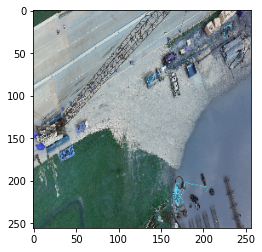

In [6]:
###############################################3
"""
data prepare
"""
dataDir=mainDir+'image/'

dataDirList=natsort.natsorted(os.listdir(dataDir),reverse=False)
allData=[]
for items in range(len(dataDirList)):
    dataPath=dataDir+'/'+dataDirList[items]    
    # print(labelDirList[items])
    oneImg=cv2.imread(dataPath)
    oneImg=cv2.resize(oneImg, (IMG_WIDTH,IMG_HEIGHT))
    # oneImg = cv2.cvtColor(oneImg, cv2.COLOR_BGR2RGB)
    plt.imshow(oneImg)
    oneImg=oneImg/255
    
    allData.append(oneImg)
    
allData=np.array(allData)


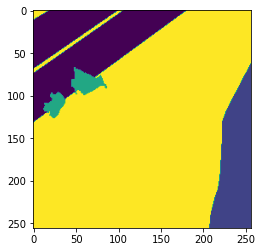

In [7]:
labelDir=mainDir+'mask/'
labelDirList=natsort.natsorted(os.listdir(labelDir),reverse=False)

allLabel=[]
for items in range(len(labelDirList)):
    labelPath=labelDir+labelDirList[items]    
    # print(labelDirList[items])
    oneImg=cv2.imread(labelPath,0)
    oneImg=cv2.resize(oneImg, (IMG_WIDTH,IMG_HEIGHT))

    plt.imshow(oneImg)
    # print(np.unique(oneImg))
    
    allLabel.append(oneImg)

allLabel=np.array(allLabel)


In [8]:
allData=np.asarray(allData)
allLabel=np.asarray(allLabel)
#allData.shape
allLabel.shape

(347, 256, 256)

In [9]:
# allLabel_cat = np.expand_dims(allLabel_cat, axis=3)
X_train, X_test, y_train, y_test  = train_test_split(
                    allData, allLabel, test_size = 0.10, random_state = 0,shuffle=True)



In [10]:
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASS)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASS)

In [12]:
"""
train model
"""
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam

##for binary class 
# myModel_binaryClass.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#for multiclass
# myModel_multiClass.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy',metrics=[MeanIoU(num_classes=2)])
myModel_binaryClass.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

history = myModel_binaryClass.fit(X_train, y_train_cat, batch_size = 4, verbose=1, epochs=5, validation_split=0.1)

Epoch 1/5
70/70 [==============================] - 236s 3s/step - loss: 1.3130 - accuracy: 0.6162 - val_loss: 1.0993 - val_accuracy: 0.6921
Epoch 2/5
70/70 [==============================] - 234s 3s/step - loss: 1.2519 - accuracy: 0.6218 - val_loss: 1.0731 - val_accuracy: 0.6921
Epoch 3/5
70/70 [==============================] - 235s 3s/step - loss: 1.2300 - accuracy: 0.6235 - val_loss: 1.0506 - val_accuracy: 0.6921
Epoch 4/5
70/70 [==============================] - 234s 3s/step - loss: 1.2171 - accuracy: 0.6236 - val_loss: 1.0692 - val_accuracy: 0.6921
Epoch 5/5
70/70 [==============================] - 235s 3s/step - loss: 1.2102 - accuracy: 0.6236 - val_loss: 1.0376 - val_accuracy: 0.6921


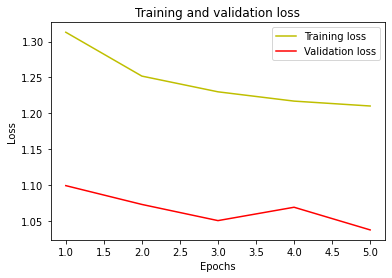

In [13]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

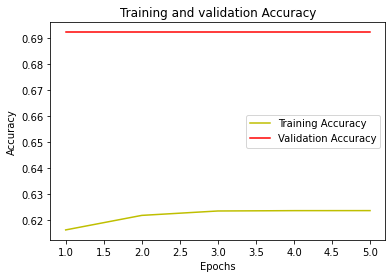

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
result=myModel_binaryClass.evaluate(X_test, y_test_cat)

print('acc========',result[1]*100)

2/2 [==============================] - 7s 615ms/step - loss: 1.2321 - accuracy: 0.5922
acc======== 59.21730995178223


In [19]:
y_pred=myModel_binaryClass.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

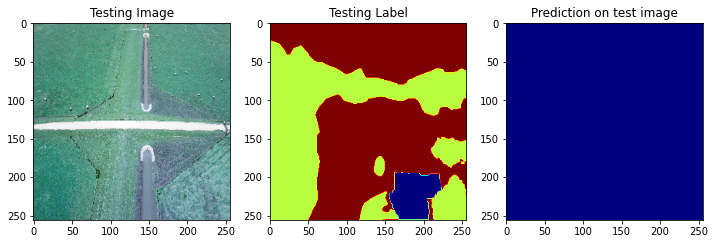

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(X_test[5], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(y_test[5], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred_argmax[5], cmap='jet')
plt.show()


In [21]:
#Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=NUM_CLASS)  
IOU_keras.update_state(y_test, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.05921731


In [22]:

values = np.array(IOU_keras.get_weights()).reshape(NUM_CLASS, NUM_CLASS)


class0_IoU=values[0,0]/(np.sum(values[0,:])+np.sum(values[:,0])-values[0,0])
class1_IoU=values[1,1]/(np.sum(values[1,:])+np.sum(values[:,1])-values[1,1])
class2_IoU=values[2,2]/(np.sum(values[2,:])+np.sum(values[:,2])-values[2,2])
class3_IoU=values[3,3]/(np.sum(values[3,:])+np.sum(values[:,3])-values[3,3])
class4_IoU=values[4,4]/(np.sum(values[4,:])+np.sum(values[:,4])-values[4,4])
class5_IoU=values[5,5]/(np.sum(values[5,:])+np.sum(values[:,5])-values[5,5])
class6_IoU=values[6,6]/(np.sum(values[6,:])+np.sum(values[:,6])-values[6,6])
class7_IoU=values[7,7]/(np.sum(values[7,:])+np.sum(values[:,7])-values[7,7])
class8_IoU=values[8,8]/(np.sum(values[8,:])+np.sum(values[:,8])-values[8,8])
class9_IoU=values[9,9]/(np.sum(values[9,:])+np.sum(values[:,9])-values[9,9])

print("IoU for class1 is: ", class0_IoU)
print("IoU for class2 is: ", class1_IoU)
print("IoU for class3 is: ", class2_IoU)
print("IoU for class4 is: ", class3_IoU)
print("IoU for class5 is: ", class4_IoU)
print("IoU for class6 is: ", class5_IoU)
print("IoU for class7 is: ", class6_IoU)
print("IoU for class8 is: ", class7_IoU)
print("IoU for class9 is: ", class8_IoU)
print("IoU for class10 is: ", class9_IoU)


sumAllIOU=class0_IoU+class1_IoU+class2_IoU+class3_IoU+class4_IoU+class5_IoU+class6_IoU+class7_IoU+class8_IoU+class9_IoU
print('\n mean of all iou',sumAllIOU/10)

IoU for class1 is:  0.0
IoU for class2 is:  0.0
IoU for class3 is:  0.0
IoU for class4 is:  0.0
IoU for class5 is:  0.0
IoU for class6 is:  0.0
IoU for class7 is:  0.0
IoU for class8 is:  0.0
IoU for class9 is:  0.0
IoU for class10 is:  0.5921731

 mean of all iou 0.059217309951782225
